Player sheet target: Ladislav Krejčí
Few/no cached values found — using fallback read from player sheet.


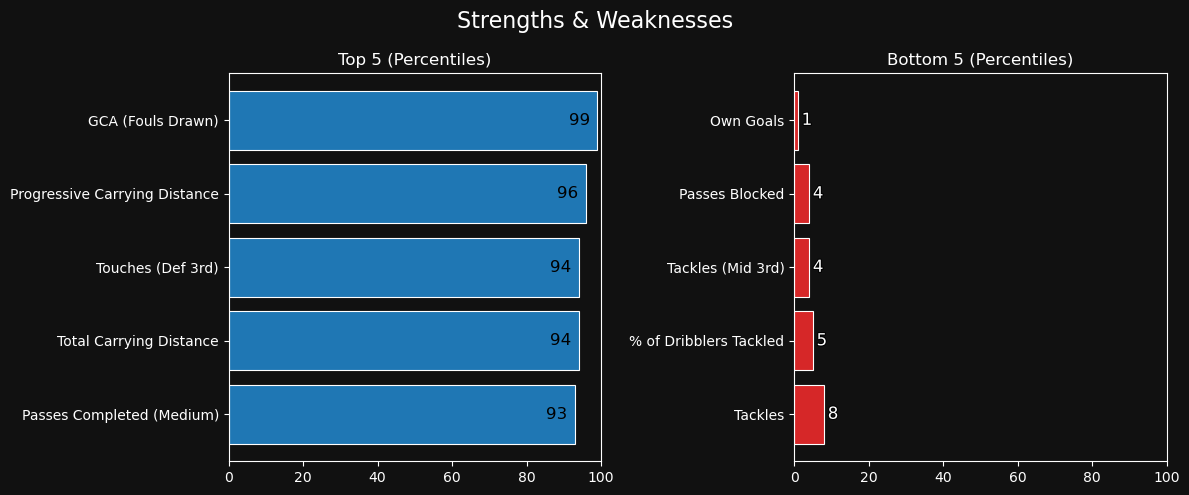

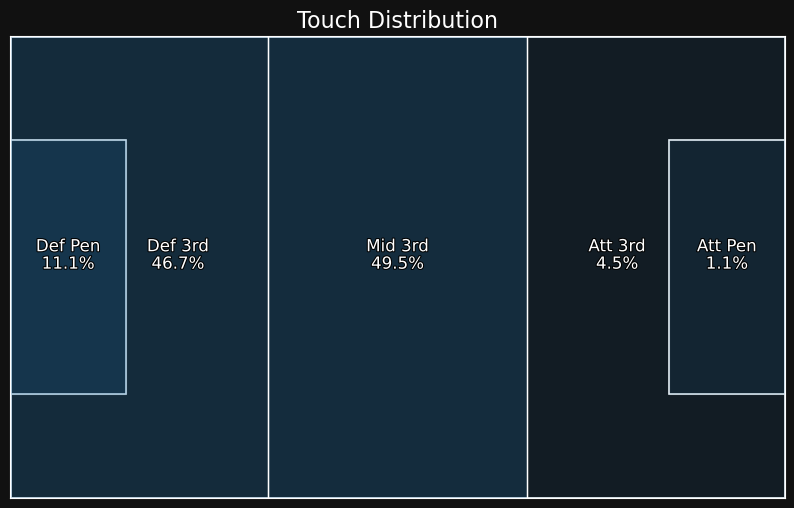

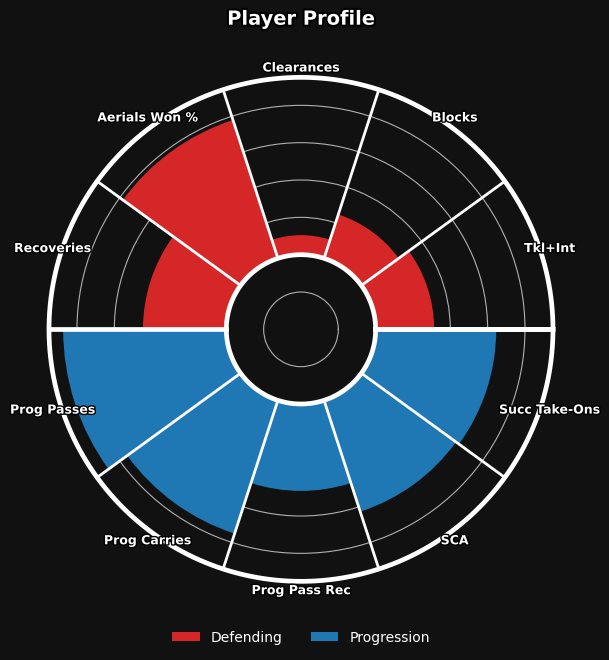

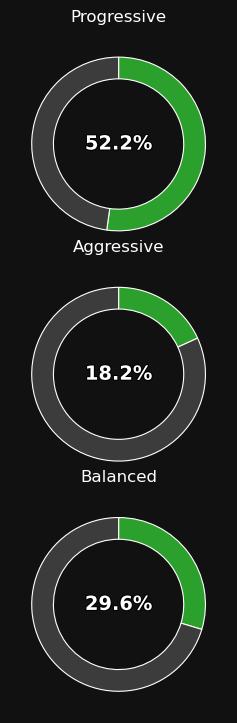

In [11]:

#SETTINGS
WORKBOOK   = "Ladislav-Krejčí.xlsx" #dataset
# OUTPUT_DIR = "dashboard_dark"
SHOW_FIGS  = True
# PRINT_SAVES= True

import pandas as pd, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle, Wedge, Circle
from matplotlib.lines import Line2D
import matplotlib.patheffects as path_effects
from openpyxl import load_workbook
from pathlib import Path

FIG_BG = AX_BG = "#111111"
SEPARATOR_COLOR = "white"
SEP_THIN  = 2.0
SEP_THICK = 3.4

TILE_BG   = "#1d1d1d"
TILE_EDGE = "#2b2b2b"
TILE_TEXT = "white"
TILE_VALUE = "white"

DEF_COLOR   = "#d62728"
PROG_COLOR  = "#1f77b4"
AERIAL_COLOR= "#ff7f0e"
PASS_COLOR  = "#2ca02c"

TITLE_FONTSIZE = 16
LABEL_FONTSIZE = 10
VALUE_FONTSIZE = 12

# Path(OUTPUT_DIR).mkdir(exist_ok=True)
mpl.rcParams.update({
    "figure.facecolor": FIG_BG,
    "axes.facecolor": AX_BG,
    "savefig.facecolor": FIG_BG,
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "text.color": "white",
})

def stroke_txt(txt, lw=1.5):
    return [path_effects.Stroke(linewidth=lw, foreground="black"), path_effects.Normal()]

def clean_axis(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(False)

# def save_fig(fig, name):
#     p = Path(OUTPUT_DIR) / f"{name}.png"
#     fig.savefig(p, dpi=200, bbox_inches="tight")
#     print(f"Saved: {p}")


#Formula Builder
def seed_sheet1_indirect_formulas(workbook_path, player_sheet_hint="Ladislav Krejčí"):
    wb = load_workbook(workbook_path)
    sheets = wb.sheetnames
    if player_sheet_hint not in sheets:
        for s in sheets:
            if s != "Sheet 1":
                player_sheet_hint = s
                break
    wb.save(workbook_path)

    #Build metrics
    raw = pd.read_excel(workbook_path, sheet_name=player_sheet_hint, header=None)
    raw.columns = ["Metric","Per90","Percentile"]
    metric_to_row = {}
    for i, r in raw.iterrows():
        m = str(r["Metric"]).strip()
        if m and m != "nan":
            metric_to_row[m] = i + 1

    from openpyxl import load_workbook as lw
    wb2 = lw(workbook_path)
    if "Sheet 1" not in wb2.sheetnames:
        ws = wb2.create_sheet("Sheet 1", 0)
    else:
        ws = wb2["Sheet 1"]
        for row in ws["A1:Z2000"]:
            for cell in row:
                cell.value = None

    ws["A1"].value = "Player Sheet Name"
    ws["A2"].value = player_sheet_hint
    ws["A4"].value = "Stat"; ws["B4"].value = "Per90"; ws["C4"].value = "Percentile"

    sheet1_fields = [
        "Goals","Assists","Non-Penalty Goals","Penalty Kicks Made",
        "xG: Expected Goals","npxG: Non-Penalty xG","xAG: Exp. Assisted Goals","npxG + xAG",
        "Shots Total","Shots on target","Shot-creating Actions","Goal-creating Actions",
        "Progressive Carries","Carries","Take-Ons Attempted","Successful Take-Ons",
        "Progressive Passes","Passes Completed","Passes Attempted","Pass Completion %",
        "Passes Completed (Short)","Passes Attempted (Short)","Pass Completion % (Short)",
        "Passes Completed (Medium)","Passes Attempted (Medium)","Pass Completion % (Medium)",
        "Passes Completed (Long)","Passes Attempted (Long)","Pass Completion % (Long)",
        "Tackles","Tackles Won","Interceptions","Blocks","Clearances","Errors",
        "Aerials Won","Aerials Lost","% of Aerials Won",
        "Touches","Touches (Def Pen)","Touches (Def 3rd)","Touches (Mid 3rd)",
        "Touches (Att 3rd)","Touches (Att Pen)","Touches (Live-Ball)",
        "Progressive Passing Distance","Total Passing Distance","Passes Received"
    ]

    r = 5
    for field in sheet1_fields:
        ws[f"A{r}"].value = field
        rn = metric_to_row.get(field)
        if rn is not None:
            per90_formula = '''=IFERROR(@INDIRECT("'" & SUBSTITUTE($A$2,"'","''") & "'!B{row}"), "")'''.format(row=rn)
            pct_formula   = '''=IFERROR(@INDIRECT("'" & SUBSTITUTE($A$2,"'","''") & "'!C{row}"), "")'''.format(row=rn)
            ws[f"B{r}"].value = per90_formula
            ws[f"C{r}"].value = pct_formula
        r += 1

    wb2.save(workbook_path)
    print(f"Sheet 1 seeded with INDIRECT formulas; player target = {player_sheet_hint}")


#load data
wb = load_workbook(WORKBOOK, data_only=True)
ws = wb["Sheet 1"] if "Sheet 1" in wb.sheetnames else None
if ws is None:
    raise RuntimeError("Sheet 1 not found. Run seed_sheet1_indirect_formulas(WORKBOOK) once.")

PLAYER_SHEET = ws["A2"].value if ws["A2"].value else "Ladislav Krejčí"
print("Player sheet target:", PLAYER_SHEET)

df = pd.read_excel(WORKBOOK, sheet_name="Sheet 1").rename(columns=lambda c: str(c).strip())
per90 = dict(zip(df.get("Stat",[]), df.get("Per90",[])))
pct   = dict(zip(df.get("Stat",[]), df.get("Percentile",[])))

if len([v for v in pct.values() if pd.notna(v)]) < 10:
    print("Few/no cached values found — using fallback read from player sheet.")
    raw = pd.read_excel(WORKBOOK, sheet_name=PLAYER_SHEET, header=None)
    raw.columns = ["Metric","Per90","Percentile"]
    per90 = {}; pct = {}
    for _, r in raw.iterrows():
        m = str(r["Metric"]).strip()
        if not m or m == "nan": continue
        try: per90[m] = float(r["Per90"])
        except: pass
        try: pct[m] = float(r["Percentile"])
        except: pass

player_name = PLAYER_SHEET


#Strengths & Weaknesses
clean_rows = [(k, v) for k, v in pct.items() if pd.notna(v)]
clean = pd.DataFrame(clean_rows, columns=["Stat","Percentile"])
top5 = clean.sort_values("Percentile", ascending=False).head(5)
bot5 = clean.sort_values("Percentile", ascending=True).head(5)

fig = plt.figure(figsize=(12,5)); fig.patch.set_facecolor(FIG_BG)
plt.suptitle(f"Strengths & Weaknesses", fontsize=16, y=0.98)

#Top 5
ax1 = fig.add_subplot(1,2,1); ax1.set_facecolor(AX_BG)
ax1.barh(top5["Stat"], top5["Percentile"], color=PROG_COLOR, edgecolor="white", linewidth=0.8)
ax1.set_xlim(0,100); ax1.invert_yaxis(); ax1.set_title("Top 5 (Percentiles)")

for y, v in enumerate(top5["Percentile"].astype(float).values):
    if np.isnan(v): 
        continue
    if v >= 8:
        ax1.text(v - 2, y, f"{v:.0f}",
                 va="center", ha="right",
                 fontsize=12, color="black", zorder=3)
    else:
        ax1.text(v + 1, y, f"{v:.0f}",
                 va="center", ha="left",
                 fontsize=12, color="white", path_effects=stroke_txt("x"), zorder=3)

#bottom 5
ax2 = fig.add_subplot(1,2,2); ax2.set_facecolor(AX_BG)
ax2.barh(bot5["Stat"], bot5["Percentile"], color=DEF_COLOR, edgecolor="white", linewidth=0.8)
ax2.set_xlim(0,100); ax2.invert_yaxis(); ax2.set_title("Bottom 5 (Percentiles)")
for y, v in enumerate(bot5["Percentile"]):
    ax2.text(v+1, y, f"{v:.0f}", va="center", fontsize=12, path_effects=stroke_txt("x"))

plt.tight_layout()
if SHOW_FIGS: plt.show()



#touch distributions
def g(name, d, default=np.nan):
    v = d.get(name, default)
    try: return float(v)
    except: return default

tot = g("Touches", per90, np.nan)
zones = [("Def Pen", g("Touches (Def Pen)", per90)),
         ("Def 3rd", g("Touches (Def 3rd)", per90)),
         ("Mid 3rd", g("Touches (Mid 3rd)", per90)),
         ("Att 3rd", g("Touches (Att 3rd)", per90)),
         ("Att Pen", g("Touches (Att Pen)", per90))]
shares = [ (0.0 if (pd.isna(tot) or tot==0 or pd.isna(v)) else v/tot) for _, v in zones ]

fig = plt.figure(figsize=(10,6)); ax = fig.add_subplot(111); ax.set_facecolor(AX_BG)
ax.add_patch(Rectangle((0,0), 120, 80, fill=False, ec="white", lw=2.0))
ax.plot([40,40],[0,80], color="white", lw=1.0); ax.plot([80,80],[0,80], color="white", lw=1.0)
ax.add_patch(Rectangle((0,18), 18, 44, fill=False, ec="white", lw=1.2))
ax.add_patch(Rectangle((102,18), 18, 44, fill=False, ec="white", lw=1.2))

fills = [ ((0,18,18,44), shares[0], "Def Pen"),
          ((0,0,40,80), shares[1], "Def 3rd"),
          ((40,0,40,80), shares[2], "Mid 3rd"),
          ((80,0,40,80), shares[3], "Att 3rd"),
          ((102,18,18,44), shares[4], "Att Pen") ]
for (x, y, w, h), s, lab in fills:
    alpha = 0.10 + 0.35 * (s)
    ax.add_patch(Rectangle((x, y), w, h, fc=PROG_COLOR, ec="white", lw=1.0, alpha=alpha))

    frac_x = 0.50
    frac_y = 0.50

    if lab == "Def 3rd":
        frac_x = 0.65  
    elif lab == "Att 3rd":
        frac_x = 0.35 

    cy = y + h * frac_y + 2.0
    cx = x + w * frac_x

    ax.text(cx, cy, f"{lab}\n{s*100:.1f}%", ha="center", va="center",
            fontsize=12, path_effects=stroke_txt("x"))

ax.set_xlim(0,120); ax.set_ylim(0,80); ax.set_xticks([]); ax.set_yticks([])
ax.set_title(f"Touch Distribution", fontsize=16)
if SHOW_FIGS: plt.show()


#Big Donut
import re, unicodedata
from pathlib import Path
from matplotlib.patches import Patch

VIS_MIN = 0.07
FLOOR_ZEROES = False

#normalized
def _norm(s):
    if s is None: return ""
    s = unicodedata.normalize("NFKC", str(s))
    s = s.replace("—","-").replace("–","-").replace("−","-")
    s = s.lower()
    return re.sub(r"[^a-z0-9]+", "", s)

pct_norm_map = {}
for k, v in pct.items():
    nk = _norm(k)
    if nk not in pct_norm_map or pd.isna(pct_norm_map[nk][1]):
        pct_norm_map[nk] = (k, v)

def get_pct_by_candidates(cands):
    """Return percentile (0..1) for the first present candidate key."""
    for c in cands:
        nk = _norm(c)
        if nk in pct_norm_map and pd.notna(pct_norm_map[nk][1]):
            try:
                return float(pct_norm_map[nk][1]) / 100.0
            except:
                pass
    return 0.0

def get_pct_exact(name):
    nk = _norm(name)
    if nk in pct_norm_map and pd.notna(pct_norm_map[nk][1]):
        try:
            return float(pct_norm_map[nk][1]) / 100.0
        except:
            return 0.0
    return 0.0

#sca fallback if not found
def get_sca_pct():
    val = get_pct_by_candidates(["Shot-creating Actions", "Shot Creating Actions", "SCA"])
    if val > 0: 
        return val
    comps = []
    for k, v in pct.items():
        if pd.isna(v): 
            continue
        ks = str(k)
        if ks.startswith("SCA (") or ks.startswith("Shot-creating Actions (") or ks.startswith("Shot Creating Actions ("):
            try:
                comps.append(float(v))
            except:
                pass
    if comps:
        return float(np.mean(comps)) / 100.0
    return 0.0

#categories
#defending
recovery_key = next((k for k in ["Recoveries", "Ball Recoveries"]
                     if _norm(k) in pct_norm_map and pd.notna(pct_norm_map[_norm(k)][1])), None)
defending_keys = [
    ("Tkl+Int", None),                     
    ("Blocks", "Blocks"),
    ("Clearances", "Clearances"),
    ("Aerials Won %", "% of Aerials Won"),
    ("Recoveries", recovery_key),          
]

#prog
recv_key = next((k for k in [
    "Progressive Passes Received", "Prog Passes Received",
    "Progressive Passes Rec", "Prog Pass Rec", "Passes Received"
] if _norm(k) in pct_norm_map and pd.notna(pct_norm_map[_norm(k)][1])), None)

sto_key = next((k for k in [
    "Successful Take-Ons", "Take-Ons Won", "Dribbles Completed", "Successful Dribbles"
] if _norm(k) in pct_norm_map and pd.notna(pct_norm_map[_norm(k)][1])), None)

progression_keys = [
    ("Prog Passes",   "Progressive Passes"),
    ("Prog Carries",  "Progressive Carries"),
    ("Prog Pass Rec", recv_key),
    ("SCA",           None),              
    ("Succ Take-Ons", sto_key),
]

def tkl_int_value():
    vals = []
    for k in ["Tackles", "Interceptions"]:
        nk = _norm(k)
        if nk in pct_norm_map and pd.notna(pct_norm_map[nk][1]):
            try:
                vals.append(float(pct_norm_map[nk][1]))
            except:
                pass
    if not vals: 
        return 0.0
    return np.clip(np.mean(vals) / 100.0, 0, 1)

labels_vals = []
labels_vals.append(("Tkl+Int", tkl_int_value()))
for lab, key in defending_keys[1:]:
    v = get_pct_exact(key) if key else 0.0
    labels_vals.append((lab, v))

for lab, key in progression_keys:
    if lab == "SCA":
        v = get_sca_pct()
    else:
        v = get_pct_exact(key) if key else 0.0
    labels_vals.append((lab, v))

vals = np.array([v for _, v in labels_vals])
if FLOOR_ZEROES:
    vals_plot = np.maximum(vals, VIS_MIN)
else:
    vals_plot = np.where(vals > 0, np.maximum(vals, VIS_MIN), 0.0)

labels = [lab for lab, _ in labels_vals]

#geometry & style
n = len(labels)
angles = np.linspace(0, 2*np.pi, n, endpoint=False)
width  = 2*np.pi / n
theta_circle = np.linspace(0, 2*np.pi, 720)

inner_radius  = 0.35
outer_radius  = inner_radius + 1.0
inner_overlay = inner_radius + 0.05
scale = outer_radius - inner_overlay

idx_def_end  = len(defending_keys)            
idx_prog_end = len(defending_keys) + len(progression_keys)
bounds = [0, idx_def_end, idx_prog_end]

def is_def(i): return i < idx_def_end
wedge_colors = [DEF_COLOR if is_def(i) else PROG_COLOR for i in range(n)]

fig = plt.figure(figsize=(7,7)); fig.patch.set_facecolor(FIG_BG)
ax  = plt.subplot(111, polar=True); ax.set_facecolor(AX_BG); ax.set_ylim(0, outer_radius)

ax.bar(angles, vals_plot * scale, width=width, bottom=inner_overlay, align="edge",
       color=wedge_colors, zorder=2)

for ang in angles:
    ax.plot([ang, ang], [inner_overlay, outer_radius], linewidth=SEP_THIN, color=SEPARATOR_COLOR, zorder=3)

for b_idx in bounds + [n]:
    ang = angles[b_idx % n]
    ax.plot([ang, ang], [inner_overlay, outer_radius], linewidth=SEP_THICK, color=SEPARATOR_COLOR, zorder=4)

ax.plot(theta_circle, np.full_like(theta_circle, outer_radius),
        color=SEPARATOR_COLOR, linewidth=SEP_THICK, zorder=5, clip_on=False)
ax.plot(theta_circle, np.full_like(theta_circle, inner_overlay),
        color=SEPARATOR_COLOR, linewidth=SEP_THICK, zorder=10, clip_on=False)

for ang, lab in zip(angles + width/2, labels):
    t = ax.text(ang, inner_radius + 1.05, lab, ha="center", va="center",
                fontsize=9, fontweight="bold", color="white", zorder=6)
    t.set_path_effects([path_effects.Stroke(linewidth=2, foreground="black"), path_effects.Normal()])

title = ax.set_title("Player Profile", va="bottom", y=1.08, fontsize=14, fontweight="bold", color="white")
title.set_path_effects([path_effects.Stroke(linewidth=3, foreground="black"), path_effects.Normal()])

#legend
legend_handles = [
    Patch(facecolor=DEF_COLOR, label="Defending"),
    Patch(facecolor=PROG_COLOR, label="Progression"),
]
leg = ax.legend(handles=legend_handles, loc="lower center", bbox_to_anchor=(0.5, -0.15),
                ncol=2, frameon=True)
plt.setp(leg.get_texts(), color="white")
leg.get_frame().set_facecolor(FIG_BG)
leg.get_frame().set_edgecolor("none")

ax.set_xticks([]); ax.set_thetagrids([]); ax.set_yticklabels([])

plt.subplots_adjust(bottom=0.16)

# safe_name = str(player_name).strip().replace(" ", "_").replace("/", "_")
# out_path = Path(OUTPUT_DIR) / f"cb_donut_{safe_name}.png"   # <-- use "/" not "|"
# Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# plt.savefig(out_path, dpi=200, bbox_inches="tight", facecolor=FIG_BG, pad_inches=0.25)
# if PRINT_SAVES: print("Saved:", out_path.resolve())
if SHOW_FIGS: plt.show()
else: plt.close(fig)

#player type
def pget(m):
    v = pct.get(m, np.nan)
    return 0.0 if pd.isna(v) else float(v)

#can change these metrics
prog_metrics = ["Progressive Passes", "Progressive Carries", "Passes Received"]
agg_metrics  = ["Tackles", "Interceptions", "Blocks"]

#avg percentiles for each bucket
prog_vals   = [pget(m) for m in prog_metrics if m in pct]
agg_vals    = [pget(m) for m in agg_metrics  if m in pct]
prog_score  = np.mean(prog_vals) if prog_vals else 0.0
agg_score   = np.mean(agg_vals)  if agg_vals  else 0.0

base_balance = 50.0
scores = np.clip(np.array([prog_score, agg_score, base_balance]), 0, 100)
pct_scores = 100.0 * scores / scores.sum() if scores.sum() > 0 else np.array([33.3, 33.3, 33.3])

pt_labels = ["Progressive", "Aggressive", "Balanced"]
pt_vals   = pct_scores.tolist()

GREEN = PASS_COLOR
GREY  = "#3c3c3c"

fig, axs = plt.subplots(
    3, 1,
    figsize=(4.4, 8.8),
    subplot_kw=dict(aspect="equal"),
    gridspec_kw={"hspace": 0.06}
)
fig.patch.set_facecolor(FIG_BG)

#donut
mid_ax = None
aggressive_title = None

for ax, lab, val in zip(axs, pt_labels, pt_vals):
    ax.set_facecolor(AX_BG)
    sizes = [float(val), max(0.0, 100.0 - float(val))]
    ax.pie(
        sizes, startangle=90, counterclock=False,
        colors=[GREEN, GREY],
        wedgeprops=dict(width=0.25, edgecolor="white", linewidth=0.8),
    )
    ax.text(0, 0, f"{val:.1f}%", ha="center", va="center",
            fontsize=14, fontweight="bold", color="white", path_effects=stroke_txt("x"))
    t = ax.set_title(lab, fontsize=12, color="white", pad=10)

    if lab == "Aggressive":
        mid_ax = ax
        aggressive_title = t

fig.canvas.draw()

bbox_ax = mid_ax.get_position(fig)
title_x = (bbox_ax.x0 + bbox_ax.x1) / 2

renderer     = fig.canvas.get_renderer()
bbox_title   = aggressive_title.get_window_extent(renderer=renderer)
bbox_titleF  = bbox_title.transformed(fig.transFigure.inverted())

SPACER = max(0.045, 1.25 * bbox_titleF.height)
title_y = bbox_titleF.y1 + SPACER

# fig.text(title_x, title_y, "Player Type",
#          ha="center", va="bottom", fontsize=TITLE_FONTSIZE, color="white")

#dont use tight_layout, will fight custom figure text placement
if SHOW_FIGS: plt.show()
# save_fig(fig, f"{player_name}_player_type_donuts_stacked")

